In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)


In [5]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
!head -12 'RF00005.fa'
#/home/ikea/GraphLearn/graphlearn/abstract_graphs/


>AB003409.1/96-167
GGGCCCAUAGCUCAGUGGUAGAGUGCCUCCUUUGCAAGGAGGAUGCCCUGGGUUCGAAUC
CCAGUGGGUCCA
>AB009835.1/1-71
CAUUAGAUGACUGAAAGCAAGUACUGGUCUCUUAAACCAUUUAAUAGUAAAUUAGCACUU
ACUUCUAAUGA
>AB013372.1/8-81
GCGCCCGUAGCUCAAUUGGAUAGAGCGUUUGACUACGGAUCAAAAGGUUAGGGGUUCGAC
UCCUCUCGGGCGCG
>AB013373.1/3754-3825
GCGGAAGUAGUUCAGUGGUAGAACACCACCUUGCCAAGGUGGGGGUCGCGGGUUCGAAUC
CCGUCUUCCGCU


In [6]:
st1= "GGGCCCAUAGCUCAGUGGUAGAGUGCCUCCUUUGCAAGGAGGAUGCCCUGGGUUCGAAUCCCAGUGGGUCCA"
st2="GCGGAAGUAGUUCAGUGGUAGAACACCACCUUGCCAAGGUGGGGGUCGCGGGUUCGAAUCCCGUCUUCCGCU"
!echo "$st2" | RNAfold

GCGGAAGUAGUUCAGUGGUAGAACACCACCUUGCCAAGGUGGGGGUCGCGGGUUCGAAUCCCGUCUUCCGCU
(((((((..((((.......)))).(((((((...))))))).....(((((.......)))))))))))). (-30.00)


In [7]:
struct="(((((((..((((.......)))).(((((((...))))))).....(((((.......))))))))))))."

import graphlearn.abstract_graphs.forgi.bulge_graph as lol
bg = lol.BulgeGraph()
bg.from_dotbracket(struct, None)
forgi = bg.to_bg_string()
print forgi

name untitled
length 72
define s0 1 7 65 71
define m0 8 9
define s1 10 13 21 24
define h0 14 20
define m2 25 25
define s2 26 32 36 42
define h1 33 35
define m3 43 47
define s3 48 52 60 64
define h2 53 59
define m1 
define t1 72 72
connect s3 h2 m1 m3
connect s2 h1 m3 m2
connect s1 h0 m0 m2
connect s0 m1 m0 t1



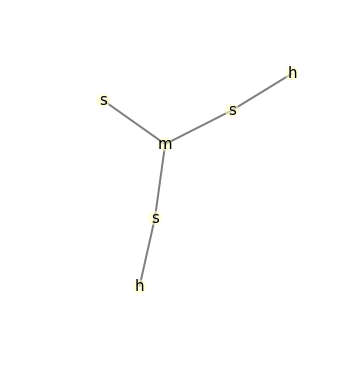

In [17]:
# here we only build the abstract graph

import networkx as nx
import graphlearn.utils.draw as draw
 
    
def forgi_to_graph(forgi):
    def make_node_set(numbers):
        '''
        forgi gives me stuff like define STEM START,END,START,END .. we take indices and output a list
        '''
        numbers=map(int,numbers)
        ans=set()
        while len(numbers)>1:
            a,b = numbers[:2]
            numbers=numbers[2:]
            for n in range(a-1,b): ans.add(n) # should be range a,b+1 but the biologists are weired
        return ans


    def get_pairs(things):

        current=[]
        for thing in things:
            if thing[0]=='m':
                current.append(thing)
            if len(current)==2:
                yield current
                current = []

    
    g=nx.Graph()
    fni={} # forgi name to networkx node id

    for l in forgi.split('\n')[:-1]:
        line= l.split()
        if line[0] not in ['define','connect']:
            continue

        # parse stuff like: define s0 1 7 65 71
        if line[0]=='define':

            # get necessary attributes for a node
            label=line[1][0]
            id=line[1]
            myset=make_node_set(line[2:])
            node_id=len(g)

            # build a node and remember its id
            g.add_node(node_id)
            fni[id]=node_id
            g.node[node_id].update( {'label':label, 'contracted':myset}  )

        # parse stuff like this: connect s3 h2 m1 m3
        if line[0]=='connect':
            # get nx name of the first element.
            hero= fni[ line[1] ]
            # connect that hero to the following elements
            for fn in line[2:]:
                g.add_edge(hero, fni[fn])
            
            # remember what pairs multiloop pieces we are part of 
            # i assume that if a stack is part of 2 multiloops they appear in order ..
            # this assumption may be wrong so be careful 
            g.node[fni[line[1]]]['multipairs']=[]
            for a,b in get_pairs(line[2:]):
                g.node[fni[line[1]]]['multipairs'].append( (fni[a],fni[b]) )
    return g


def connect_multiloop(g):
    def merge(graph, node, node2):
        '''
        merge node2 into the node.
        input nodes are strings,
        node is the king
        '''
        for n in graph.neighbors(node2):
            graph.add_edge(node, n)
        graph.node[node]['contracted'].update(graph.node[node2]['contracted'])
        graph.remove_node(node2)

    
    merge_dict={}
    for node,d in g.nodes(data=True):
        if d['label'] == 's':
            for a,b in g.node[node]['multipairs']:
                # finding real names... this works by walking up the 
                #ladder merge history until the root is found :) 
                while a not in g:
                    a=merge_dict[a]
                while b not in g:
                    b=merge_dict[b]
                if a==b:
                    continue
                merge_dict[b]=a
                merge(g,a,b)
                



g=forgi_to_graph(forgi)
#draw.graphlearn_draw(g, vertex_label='id')        
connect_multiloop(g)    



draw.graphlearn_draw(g)  

In [ ]:


s=set(range(3))

In [ ]:
min(s)

In [18]:
# get name,seq,shape from a rnafolder



# RNAfold
def feedme(s):
    s=!RNAfold --noPS < RF00005.fa
    while len(s)>3:
        a,b,c = s[:3] 
        s=s[3:]
        c=c.split()[0]
        yield a,b,c  # name, seq, str

# RNAshapes
def readfasta():
    s= !cat RF00005.fa
    while s:
        seqname=s[0]
        seq=''
        for i,l in enumerate(s[1:]):
            if l[0] != '>':
                seq+=l
            else:
                break
        yield seqname,seq
        s=s[i+1:]
    
def feedme(zz):
    for name,seq in readfasta():
        #print seq
        s=!RNAshapes $seq
        for li in s[2:]:  
            #print li.split()
            energy,shape,abstr= li.split()
            if abstr=='[[][][]]':
                yield name,seq,shape
        
#debug
def feedme(s):
    stru='((..((..))..((..))))'
    yield 'blub','0'*len(stru),stru    

In [19]:
# see what comes out of the folder
import itertools
for a in itertools.islice(feedme(3),3):
    print a


('blub', '00000000000000000000', '((..((..))..((..))))')


blub 00000000000000000000 ((..((..))..((..))))


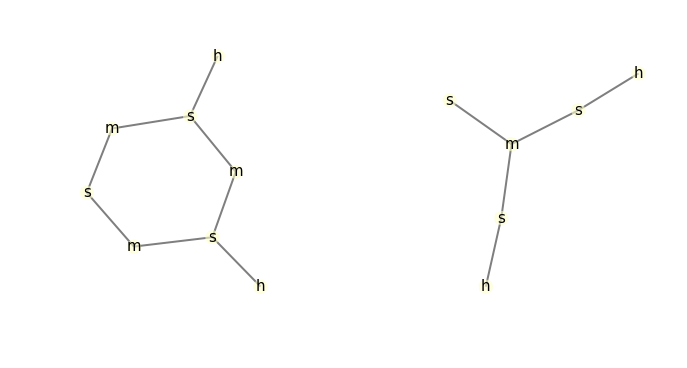

In [20]:
import graphlearn.abstract_graphs.forgi.bulge_graph as lol
import itertools
rez=[]
for name,seq,struct in itertools.islice(feedme(3),5):
    print name,seq,struct
    # get forgi string
    bg = lol.BulgeGraph()
    bg.from_dotbracket(struct, None)
    forgi = bg.to_bg_string()
    
    # create abstract graph
    g=forgi_to_graph(forgi)
    g2=g.copy()
    connect_multiloop(g2)
    
    # draw before and after connect multiloop
    draw.graphlearn_draw([g,g2])
    
    #save  abstract-graph, sequence , structure
    rez.append((g2,seq,struct)) 

    

((..((..))..((..))))


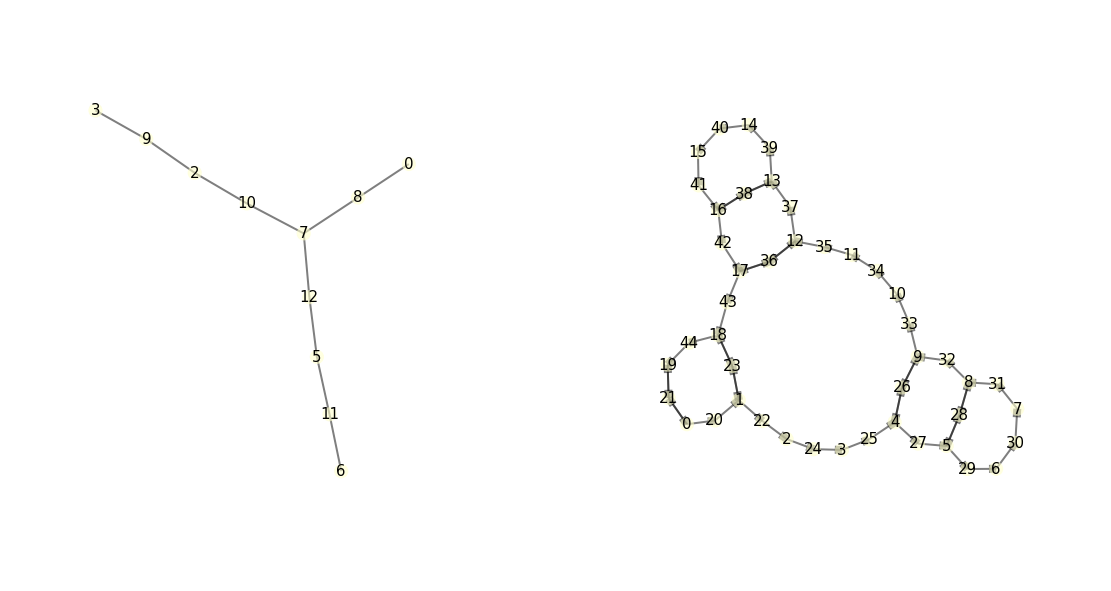

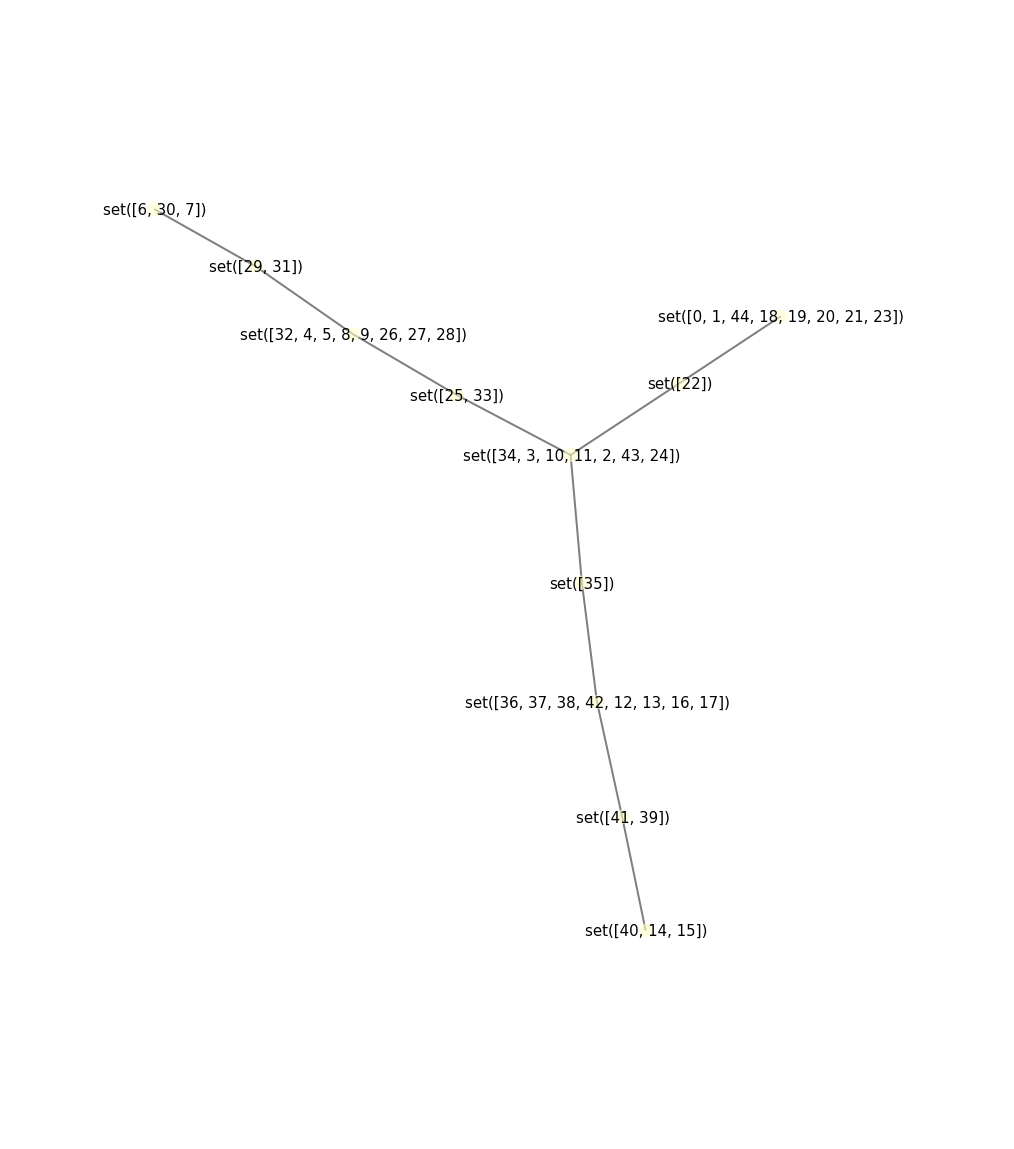

In [22]:
"""
THE PLAN
create underlying graph.
expand and direct
see if we can map 
"""
def ubersamplers_edge_parent_finder(abstract,graph):
    # find out to which abstract node the edges belong
    # finding out where the edge-nodes belong, because the contractor cant possibly do this
    #draw.graphlearn_draw([abstract,graph],size=10, contract=False,vertex_label='id')
    getabstr = {contra: node for node, d in abstract.nodes(data=True) for contra in d.get('contracted', [])}
    #print getabstr
    for n, d in graph.nodes(data=True):
        if 'edge' in d:
            # if we have found an edge node...
            # lets see whos left and right of it:
            zomg= graph.neighbors(n)
            #print zomg
            #draw.draw_center(graph,1,20,contract=False,size=20)
            n1, n2 = zomg
            
            # case1: ok those belong to the same gang so we most likely also belong there.
            if getabstr[n1] == getabstr[n2]:
                abstract.node[getabstr[n1]]['contracted'].add(n)

            # case2: neighbors belong to different gangs...
            else:
                abstract_intersect = set(abstract.neighbors(getabstr[n1])) & set(abstract.neighbors(getabstr[n2]))
                
                # case 3: abstract intersect in radius 1 failed, so lets try radius 2 
                if not abstract_intersect:
                    abstract_intersect = set(nx.single_source_shortest_path(abstract,getabstr[n1],2)) & set(nx.single_source_shortest_path(abstract,getabstr[n2],2))
                    if len(abstract_intersect) > 1:
                        print "weired abs intersect..."
                    
                for ai_node in abstract_intersect:
                    if 'contracted' in abstract.node[ai_node]:
                        abstract.node[ai_node]['contracted'].add(n)
                    else:
                        abstract.node[ai_node]['contracted'] = set([n])
                        
                        
    return abstract



def create_nesting(astr,graph):
    z=nx.disjoint_union(graph,astr)
    for node,d in z.nodes(data=True):
        for c in d.get('contracted',[]):
            z.add_edge(node,c,{'nesting':True})
    return z
        

import eden.converter.rna as conv
from eden.graph import Vectorizer

import graphlearn.abstract_graphs.rnasampler as rna
v=Vectorizer()

for g,se,st in rez:
    print st
    
    # create a base_graph , expand
    base_graph=conv.sequence_dotbracket_to_graph(seq_info=se, seq_struct=st)
    bg=v._edge_to_vertex_transform(base_graph)
    
    
    # expand abstract graph as well
    g=v._edge_to_vertex_transform(g)
    
    #connect edges to nodes in the abstract graph
    g=ubersamplers_edge_parent_finder(g,bg)
    
    
    # make base graph directed
    bg=rna.expanded_rna_graph_to_digraph(bg)
    
    # merge the abstract and the real graph
    nested_graph=create_nesting(g,bg)
    
    # draw
    draw.graphlearn_draw([g,bg],size=10, contract=False,vertex_label='id')
    draw.graphlearn_draw(g,size=20, contract=False,vertex_label='contracted')
    

In [3]:
import networkx as nx
import graphlearn.utils.draw as draw
g=nx.path_graph(5)
f=nx.path_graph(4)
z=nx.disjoint_union(g,f)
draw.graphlearn_draw(z,vertex_label='id')
draw.graphlearn_draw(f,vertex_label='id')
draw.graphlearn_draw(g,vertex_label='id')

/home/ikea/.local/lib/python2.7/site-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 7 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)
/home/ikea/.local/lib/python2.7/site-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 186 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)
/home/ikea/.local/lib/python2.7/site-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 361 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


In [65]:
r=range(4)
map(str,r)

['0', '1', '2', '3']

In [12]:
class lol:
    def __init__(self):
        self.z=5
    
lol2=lol

z=lol2()
b=lol2()

z.z=3
b.z






5